In [1]:
import pandas as pd
import numpy as np
import keras
import glob
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from mlxtend.preprocessing import minmax_scaling
from sklearn.metrics import roc_curve, auc

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from keras.optimizers import RMSprop, SGD
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras import backend as K

import os

In [2]:
# find file paths
plastic = ['NoPlastic','PlasticOnWater', 'PlasticUnderWater'] 
f_no_plastic = glob.glob('../Dataset/Train/'+plastic[0]+'/*')
f_plastic_on_water_surface = glob.glob('../Dataset/Train/'+plastic[1]+'/*')
f_plastic_under_water = glob.glob('../Dataset/Train/'+plastic[2]+'/*')
f_no_plastic_test = glob.glob('../Dataset/Test/'+plastic[0]+'/*')
f_plastic_on_water_surface_test = glob.glob('../Dataset/Test/'+plastic[1]+'/*')
f_plastic_under_water_test = glob.glob('../Dataset/Test/'+plastic[2]+'/*')
print('Number of images per class:\n\t\ttrain\ttest \nNo_Plastic:\t{}\t{}\nPlastic_On_WaterSurface:\t{}\t{}\nPlastic_Under_Water:\t{}\t{}'
      .format(len(f_no_plastic),len(f_no_plastic_test),len(f_plastic_on_water_surface),len(f_plastic_on_water_surface_test),len(f_plastic_under_water),len(f_plastic_under_water_test)))

Number of images per class:
		train	test 
No_Plastic:	1306	63
Plastic_On_WaterSurface:	500	46
Plastic_Under_Water:	1427	624


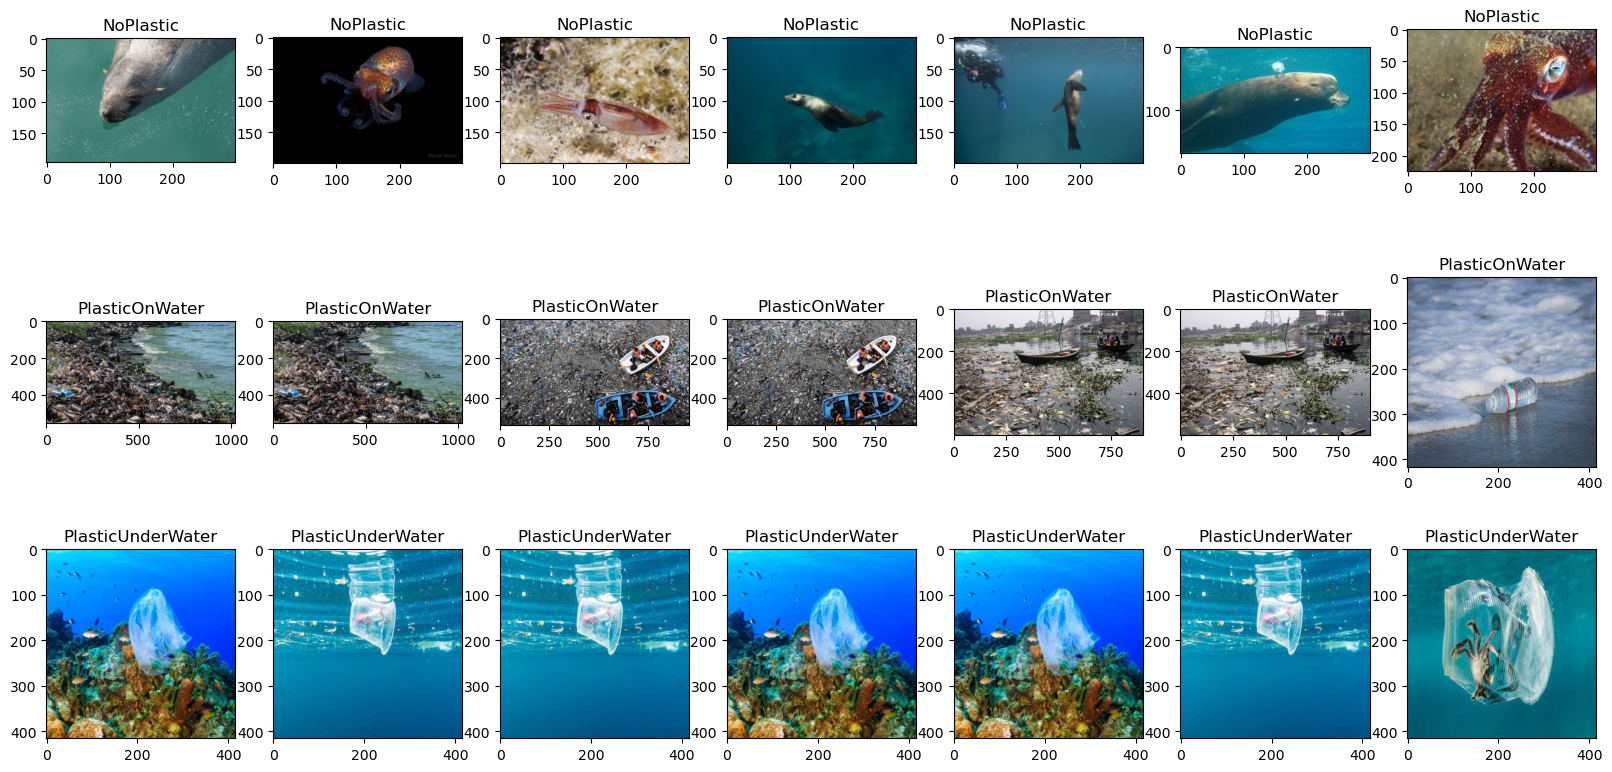

In [3]:
# preview some images of each class
n = 7
fig, axes = plt.subplots(3,n,figsize=(20,10))

for i in range(n):
    axes[0, i].imshow(plt.imread(f_no_plastic[i]))
    axes[0, i].set_title('NoPlastic')
    axes[1, i].imshow(plt.imread(f_plastic_on_water_surface[i]))
    axes[1, i].set_title('PlasticOnWater')
    axes[2, i].imshow(plt.imread(f_plastic_under_water[i]))
    axes[2, i].set_title('PlasticUnderWater')

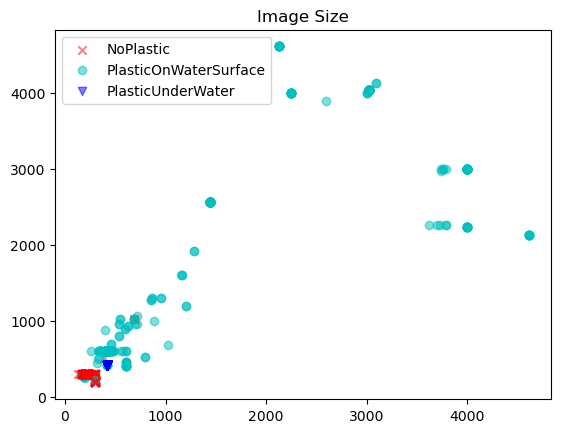

In [4]:
for i in range(len(f_plastic_on_water_surface)):
    h1,w1,c1 = plt.imread(f_no_plastic[i]).shape
    h2,w2,c2 = plt.imread(f_plastic_on_water_surface[i]).shape
    h3,w3,c3 = plt.imread(f_plastic_under_water[i]).shape
    plt.scatter(h1,w1,c='r',marker='x',alpha=0.5)
    plt.scatter(h2,w2,c='c',marker='o',alpha=0.5)
    plt.scatter(h3,w3,c='b',marker='v',alpha=0.5)
plt.title('Image Size')
plt.legend(('NoPlastic','PlasticOnWaterSurface','PlasticUnderWater'))

In [5]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 shear_range=0.2,
                 zoom_range=0.2,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1/255) #rescale to [0-1], add zoom range of 0.2x and horizontal flip
train_generator = train_datagen.flow_from_directory(
        "../Dataset/Train/",
        target_size=(224,224),
        batch_size=30)
test_datagen = ImageDataGenerator(rescale=1/255) # just rescale to [0-1] for testing set
test_generator = test_datagen.flow_from_directory(
        "../Dataset/Test/",
        target_size=(224,224),
        batch_size=30)

Found 3233 images belonging to 3 classes.
Found 733 images belonging to 3 classes.


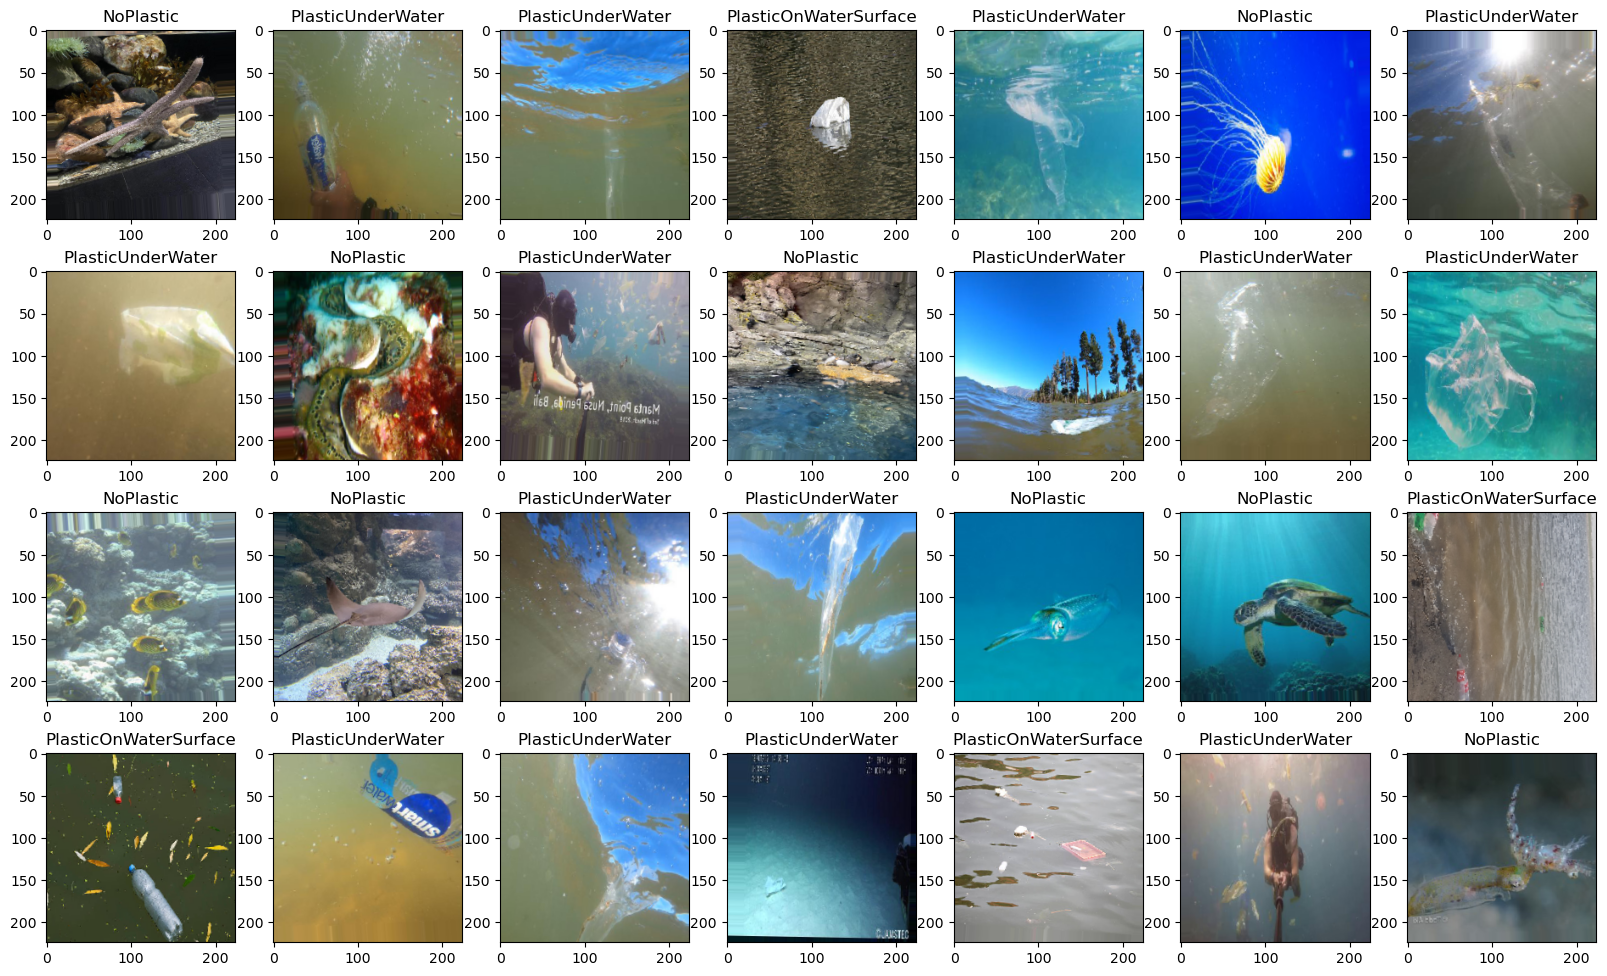

In [6]:
# preview images from train generator
r = 4; c = 7
n=0
classtolabel = {'0':'NoPlastic','1':'PlasticOnWaterSurface','2':'PlasticUnderWater'}
for x in train_generator:
    fig, axes = plt.subplots(r,c,figsize=(20,12))
    for i in range(r):
        for j in range(c):
            axes[i,j].imshow(x[0][n])
            label = np.argmax(x[1],axis=1)[n].astype('str')
            axes[i,j].set_title(classtolabel[label])
            n+=1    
    break

In [7]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu', input_shape = (224,224,3), kernel_initializer='he_normal'))
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation = "relu",kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(3, activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=l2()))

#callbacks
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        36928     
                                                        

In [11]:
history = model.fit(train_generator,steps_per_epoch=2250/64,
                              validation_data=test_generator,validation_steps=750/64, 
                              epochs=50, callbacks=[checkpointer, reduceLR, earlystopping])

Epoch 1/50
36/35 [==============================] - ETA: 0s - loss: 0.4128 - accuracy: 0.8481
Epoch 1: val_loss did not improve from 0.56809
35/35 [==============================] - 32s 923ms/step - loss: 0.4128 - accuracy: 0.8481 - val_loss: 0.6048 - val_accuracy: 0.7611 - lr: 0.0010
Epoch 2/50
36/35 [==============================] - ETA: 0s - loss: 0.4532 - accuracy: 0.8360
Epoch 2: val_loss did not improve from 0.56809
35/35 [==============================] - 34s 966ms/step - loss: 0.4532 - accuracy: 0.8360 - val_loss: 0.8012 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 3/50
36/35 [==============================] - ETA: 0s - loss: 0.4832 - accuracy: 0.8173
Epoch 3: val_loss did not improve from 0.56809
35/35 [==============================] - 34s 983ms/step - loss: 0.4832 - accuracy: 0.8173 - val_loss: 1.0609 - val_accuracy: 0.5389 - lr: 0.0010
Epoch 4/50
36/35 [==============================] - ETA: 0s - loss: 0.3836 - accuracy: 0.8657
Epoch 4: val_loss did not improve from 0.56809
3

In [14]:
# create another generator for all test images in a single batch 
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = test_datagen.flow_from_directory(
        "../Dataset/Test/",
        target_size=(224,224),
        batch_size=40)

Found 733 images belonging to 3 classes.


In [15]:
x_test, y_test = val_generator.next()
y_pred_conf = model.predict(x_test) #return probabilities of each class
y_pred = np.argmax(y_pred_conf,axis=1)
y_label = np.argmax(y_test,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_pred,y_label)*100))

2/2 [==============================] - 0s 20ms/step
Accuracy score: 65.0%


In [16]:
model.save('finalver.h5')